#### Imports

In [1]:
import torch
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import scipy
from datetime import datetime
import json
import time
import math


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.insert(0, module_path)

import Double_Pendulum.Learning.autoencoders as autoencoders
import Double_Pendulum.robot_parameters as robot_parameters
import Double_Pendulum.transforms as transforms
import Double_Pendulum.dynamics as dynamics
import Plotting.pendulum_plot as pendulum_plot


import plot_collocated as plt_col

from functools import partial

import matplotlib
matplotlib.rcParams['font.family']   = 'serif'
matplotlib.rcParams['font.serif']    = ['Times New Roman']
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'



%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Parameter definitions

In [2]:
rp = robot_parameters.LUMPED_PARAMETERS
plotter = pendulum_plot.Anim_plotter(rp)

model_cw = False

model_ana = autoencoders.Analytic_transformer(rp)

#### Gains

In [3]:
# Controller gains in theta-space
Kp = torch.tensor([[100., 0.], 
				   [0., 0.]]).to(device)
Kd = torch.tensor([[40., 0.], 
				   [0., 0.]]).to(device)

# Controller gains in q-space
Kp_naive = torch.tensor([[100., 50.]]).to(device)
Kd_naive = torch.tensor([[50., 30.]]).to(device)

K_naive = torch.cat((Kp_naive, Kd_naive), dim=1).squeeze(0)

#### Time definitions

In [4]:
settling_time_threshold = 0.05

dt = 0.01
t_end = 15.
t_series = torch.arange(0, t_end, dt)

#### Define performance logger

In [5]:
def load_performance_dict(load_performance_path):
	performance_dict = torch.load(load_performance_path)#, map_location = "cpu")
	print(f"Loaded performance dicts from {load_performance_path}")
	return performance_dict

In [6]:
def save_performance_dict(performance_dict, save_folder, file_name):

	save_performance_path = save_folder + "/" + file_name

	torch.save(performance_dict, save_performance_path)
	print(f"Saved performance dicts to {save_performance_path}")

#### Define desired conditions

In [7]:
def desired_conditions(xy_des, model):
	q_des = transforms.inverse_kinematics(xy_des, rp, is_clockwise=model_cw).unsqueeze(0)
	q_d_des = torch.tensor([[0., 0.]]).requires_grad_().to(device)

	is_clockwise_des = transforms.check_clockwise(q_des.squeeze(0))

	th_des_ana = model_ana.encoder_vmap(q_des)
	th_d_des_ana = (model_ana.jacobian_enc(q_des) @ q_d_des.T).T

	th_des_est = model.encoder_vmap(q_des)
	th_d_des_est = (model.jacobian_enc(q_des) @ q_d_des.T).T

	q_des_est = model.decoder_vmap(th_des_est, is_clockwise_des)
	q_d_des_est = (model.jacobian_dec(th_des_est, clockwise=is_clockwise_des) @ th_d_des_est.T).T
	xy_des_est, _ = transforms.forward_kinematics(rp, q_des_est[0])

	#print("xy_des:", xy_des.detach().cpu().numpy())
	#print("th_des_ana:", th_des_ana.detach().cpu().numpy()[0])

	return (q_des, q_d_des, is_clockwise_des, th_des_ana, th_d_des_ana, 
		 	th_des_est, th_d_des_est, q_des_est, q_d_des_est, xy_des_est)

#### Define start conditions

In [8]:
def start_conditions(xy_start, model):
	q_start = transforms.inverse_kinematics(xy_start, rp, is_clockwise=model_cw).unsqueeze(0)
	q_d_start = torch.tensor([[0., 0.]]).requires_grad_().to(device)
	q_dd_start = torch.tensor([[0., 0.]]).requires_grad_().to(device)

	is_clockwise_start = transforms.check_clockwise(q_start.squeeze(0))

	th_start_est = model.encoder_vmap(q_start)
	th_d_start_est = (model.jacobian_enc(q_start) @ q_d_start.T).T

	th_start_ana = model_ana.encoder_vmap(q_start)
	th_d_start_ana = (model_ana.jacobian_enc(q_start) @ q_d_start.T).T

	q_start_est = model.decoder_vmap(th_start_est, is_clockwise_start)
	q_d_start_est = (model.jacobian_dec(th_start_est, clockwise=is_clockwise_start) @ th_d_start_est.T).T
	xy_start_est, _ = transforms.forward_kinematics(rp, q_start_est[0])

	#print("xy_start:", xy_start.detach().cpu().numpy())
	#print("th_start_ana:", th_start_ana.detach().cpu().numpy()[0])

	return (q_start, q_d_start, q_dd_start, is_clockwise_start, th_start_est, th_d_start_est, 
		 	th_start_ana, th_d_start_ana, q_start_est, q_d_start_est, xy_start_est)

#### NN simulation

In [9]:
def sim_collocated_nn(xy_start, xy_des, timestamp, model_nn, C_damp):

	(q_des, q_d_des, is_clockwise_des, th_des_ana, th_d_des_ana, 
		th_des_est, th_d_des_est, q_des_est, q_d_des_est, xy_des_est) = desired_conditions(xy_des, model_nn)

	(q_start, q_d_start, q_dd_start, is_clockwise_start, th_start_est, th_d_start_est, 
		th_start_ana, th_d_start_ana, q_start_est, q_d_start_est, xy_start_est) = start_conditions(xy_start, model_nn)
	

	num_steps = int(t_end / dt)
	th_series, th_d_series      = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	th_ana_series, th_d_ana_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_hat_series, q_d_hat_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_real_series, q_d_real_series, q_dd_real_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	u_series = torch.empty((num_steps, 1)).to(device)
	tau_q_series = torch.empty((num_steps, 2)).to(device)

	# Define starting conditions
	th = th_start_est
	th_d = th_d_start_est

	q_hat = q_start_est
	q_d_hat = q_d_start_est

	q_real, q_d_real, q_dd_real = q_start, q_d_start, q_dd_start

	is_clockwise = transforms.check_clockwise(q_start.squeeze(0))



	for i, t in enumerate(torch.arange(0, t_end, dt)):
		t_string = "Time: [" + str(t.item().__round__(3)) + "/" + str(t_end) + ".0]"
		if torch.allclose(t, torch.floor(t)) and torch.floor(t)%5 == 0:
			print(t_string)

		is_clockwise = transforms.check_clockwise(q_real.squeeze(0))
		if model_cw != is_clockwise:
			print("fixing value to", "clockwise" if model_cw else "counterclockwise")
			q = transforms.flip_q(rp, q_real.squeeze(0), model_cw).unsqueeze(0)
			q_d = transforms.flip_q_d(rp, q_real.squeeze(0), q_d_real, model_cw)
		else:
			q = q_real
			q_d = q_d_real

		th = model_nn.encoder_vmap(q)
		th_d = (model_nn.jacobian_enc(q) @ q_d.T).T
		
		q_hat = model_nn.decoder_vmap(th, clockwise=model_cw)
		q_d_hat = (model_nn.jacobian_dec(th) @ th_d.T).T

		is_clockwise = transforms.check_clockwise(q_hat.squeeze(0))

		""" Obtain Jacobian, dynamical matrices"""
		
		J_h_inv = model_nn.jacobian_dec(th, is_clockwise).squeeze(0)
		J_h_inv_trans = torch.transpose(J_h_inv, 0, 1)

		M_q_est, C_q_est, G_q_est = dynamics.dynamical_matrices(rp, q_hat.squeeze(0), q_d_hat.squeeze(0))
		A_q_est = dynamics.input_matrix(rp, q_hat.squeeze(0))


		# Compute the M_th Jacobian
		calc_M_th_partial = partial(transforms.calc_M_th_from_th, rp=rp, model=model_nn, model_cw=False)
		dM_th = torch.autograd.functional.jacobian(calc_M_th_partial, th).squeeze()

		""" Feed-forward simulation of the system, not on real dynamics """

		M_th = transforms.transform_M_th(M_q_est, J_h_inv, J_h_inv_trans)
		C_th = transforms.transform_C_th(dM_th, th_d)
		G_th = transforms.transform_G_th(G_q_est, J_h_inv_trans)

		A_th = transforms.transform_input_matrix_from_inverse_trans(A_q_est, J_h_inv_trans)

		u = torch.pinverse(A_th) @ ((Kp @ (th_des_est - th).T + Kd @ (th_d_des_est - th_d).T))
		u = u + torch.pinverse(A_th) @ G_th

		""" Update the real system and apply latent control input. """

		M_q_real, C_q_real, G_q_real = dynamics.dynamical_matrices(rp, q_real.squeeze(0), q_d_real.squeeze(0))
		A_q_real = dynamics.input_matrix(rp, q_real.squeeze(0))

		tau_q_real = A_q_real * u
		q_dd_real = (torch.pinverse(M_q_real) @ (tau_q_real - C_q_real @ ((q_d_real).T) - (C_damp @ ((q_d_real).T)) - G_q_real)).T
		q_d_real = q_d_real + q_dd_real * dt
		q_real = q_real + q_d_real * dt
		q_real = transforms.wrap_to_pi(q_real)
		
		th = model_nn.encoder_vmap(q_real)
		q_hat = model_nn.decoder_vmap(th, clockwise=transforms.check_clockwise(q_real.squeeze(0)))
		q_hat = transforms.wrap_to_pi(q_hat)
		th_d = (model_nn.jacobian_enc(q_real) @ q_d_real.T).T
		q_d_hat = (model_nn.jacobian_dec(th, clockwise=is_clockwise) @ th_d.T).T

		th_ana = model_ana.encoder_vmap(q_real)
		th_d_ana = (model_ana.jacobian_enc(q_real) @ q_d_real.T).T



		""" Store data for plotting """

		th_series[i] = th.detach()
		th_d_series[i] = th_d.detach()

		th_ana_series[i] = th_ana.detach()
		th_d_ana_series[i] = th_d_ana.detach()

		q_real_series[i] = q_real.detach()
		q_d_real_series[i] = q_d_real.detach()
		q_dd_real_series[i] = q_dd_real.detach()

		q_hat_series[i] = q_hat.detach()
		q_d_hat_series[i] = q_d_hat.detach()

		u_series[i] = u.detach()
		tau_q_series[i] = tau_q_real.T.detach()


	xy_real_series = torch.empty(q_real_series.size()).to(device)
	xy_hat_series = torch.empty(q_real_series.size()).to(device)

	for i, (q_real, q_hat) in enumerate(zip(q_real_series, q_hat_series)):
		xy_real, _ = transforms.forward_kinematics(rp, q_real)
		xy_real_series[i] = xy_real.unsqueeze(0)
		xy_hat, _ = transforms.forward_kinematics(rp, q_hat)
		xy_hat_series[i] = xy_hat.unsqueeze(0)

	nn_sim_data = {
		"th_s": th_series,
		"th_d_s": th_d_series,
		"th_ana_s": th_ana_series,
		"th_d_ana_s": th_d_ana_series,
		"q_real_s": q_real_series,
		"q_d_real_s": q_d_real_series,
		"q_dd_real_s": q_dd_real_series,
		"q_hat_s": q_hat_series,
		"q_d_hat_s": q_d_hat_series,
		"xy_real_s": xy_real_series,
		"xy_hat_s": xy_hat_series,
		"u_s": u_series,
		"tau_q_s": tau_q_series
	}

	return (nn_sim_data, q_des, q_start, th_des_ana, th_start_ana)

#### Analytic simulation

In [10]:
def sim_collocated_ana(xy_start, xy_des, timestamp, model, C_damp):


	(q_des, q_d_des, is_clockwise_des, th_des_ana, th_d_des_ana, 
		th_des_est, th_d_des_est, q_des_est, q_d_des_est, xy_des_est) = desired_conditions(xy_des, model_ana)

	(q_start, q_d_start, q_dd_start, is_clockwise_start, th_start_est, th_d_start_est, 
		th_start_ana, th_d_start_ana, q_start_est, q_d_start_est, xy_start_est) = start_conditions(xy_start, model_ana)


	num_steps = int(t_end / dt)
	th_ana_series, th_d_ana_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_ana_series, q_d_ana_series, q_dd_ana_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_hat_ana_series, q_d_hat_ana_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)

	u_ana_series = torch.empty((num_steps, 1)).to(device)
	tau_q_ana_series = torch.empty((num_steps, 2)).to(device)

	# Define starting angles
	q, q_d, q_dd = q_start, q_d_start, q_dd_start

	is_clockwise = False
	

	for i, t in enumerate(torch.arange(0, t_end, dt)):
		t_string = "Time: [" + str(t.item().__round__(3)) + "/" + str(t_end) + ".0]"
		if torch.allclose(t, torch.floor(t)) and torch.floor(t)%5 == 0:
			print(t_string)

		
		th = model.encoder_vmap(q)
		th_d = (model.jacobian_enc(q) @ q_d.T).T
	
			
		q_hat = model.decoder_vmap(th, clockwise=model_cw)
		q_d_hat = (model.jacobian_dec(th) @ th_d.T).T


		""" Obtain Jacobian, dynamical matrices"""
		
		J_h_inv = model.jacobian_dec(th, is_clockwise).squeeze(0)
		J_h_inv_trans = torch.transpose(J_h_inv, 0, 1)

		M_q_est, C_q_est, G_q_est = dynamics.dynamical_matrices(rp, q_hat.squeeze(0), q_d_hat.squeeze(0))
		A_q_est = dynamics.input_matrix(rp, q_hat.squeeze(0))

		""" Feed-forward simulation of the system, not on real dynamics """
		

		# Compute the Jacobian
		
		calc_M_th_partial = partial(transforms.calc_M_th_from_th, rp=rp, model=model_ana, model_cw=False)
		dM_th = torch.autograd.functional.jacobian(calc_M_th_partial, th).squeeze()
		""" Feed-forward simulation of the system, not on real dynamics """
		
		M_th = transforms.transform_M_th(M_q_est, J_h_inv, J_h_inv_trans)
		C_th = transforms.transform_C_th(dM_th, th_d)
		G_th = transforms.transform_G_th(G_q_est, J_h_inv_trans)

		A_th = transforms.transform_input_matrix_from_inverse_trans(A_q_est, J_h_inv_trans)
		
		u = torch.pinverse(A_th) @ ((Kp @ (th_des_ana - th).T + Kd @ (th_d_des_ana - th_d).T))
		u = u + torch.pinverse(A_th) @ G_th

		""" Update the real system and apply latent control input. """
		
		M_q_real, C_q_real, G_q_real = dynamics.dynamical_matrices(rp, q.squeeze(0), q_d.squeeze(0))
		A_q_real = dynamics.input_matrix(rp, q.squeeze(0))


		
		tau_q_real = A_q_real * u
		q_dd = (torch.pinverse(M_q_real) @ (tau_q_real - C_q_real @ ((q_d).T) - (C_damp @ ((q_d).T)) - G_q_real)).T
		q_d = q_d + q_dd * dt
		q = q + q_d * dt
		q = transforms.wrap_to_pi(q)


		
		th_ana = model.encoder_vmap(q)
		th_d_ana = (model.jacobian_enc(q) @ q_d.T).T

		""" Store data for plotting """
		
		th_ana_series[i] = th_ana.detach()
		th_d_ana_series[i] = th_d_ana.detach()

		q_ana_series[i] = q.detach()
		q_d_ana_series[i] = q_d.detach()
		q_dd_ana_series[i] = q_dd.detach()

		q_hat_ana_series[i] = q_hat.detach()
		q_d_hat_ana_series[i] = q_d_hat.detach()

		u_ana_series[i] = u.detach()
		tau_q_ana_series[i] = tau_q_real.T.detach()

	xy_real_series = torch.empty(q_ana_series.size()).to(device)
	xy_hat_series = torch.empty(q_hat_ana_series.size()).to(device)

	for i, (q_real, q_hat) in enumerate(zip(q_ana_series, q_hat_ana_series)):
		xy_real, _ = transforms.forward_kinematics(rp, q_real)
		xy_real_series[i] = xy_real.unsqueeze(0)
		xy_hat, _ = transforms.forward_kinematics(rp, q_hat)
		xy_hat_series[i] = xy_hat.unsqueeze(0)

	ana_sim_data = {
		"th_ana_s": th_ana_series,
		"th_d_ana_s": th_d_ana_series,
		"q_real_s": q_ana_series,
		"q_d_real_s": q_d_ana_series,
		"q_dd_real_s": q_dd_ana_series,
		"q_hat_ana_s": q_hat_ana_series,
		"q_d_hat_ana_s": q_d_hat_ana_series,
		"u_s": u_ana_series,
		"tau_q_ana_s": tau_q_ana_series,
		"xy_real_s": xy_real_series,
		"xy_hat_s": xy_hat_series,
	}

	return ana_sim_data


		


#### Naive simulation

In [11]:
def sim_collocated_naive(xy_start, xy_des, timestamp, C_damp):


	(q_des, q_d_des, is_clockwise_des, th_des_ana, th_d_des_ana, 
		th_des_est, th_d_des_est, q_des_est, q_d_des_est, xy_des_est) = desired_conditions(xy_des, model_ana)

	(q_start, q_d_start, q_dd_start, is_clockwise_start, th_start_est, th_d_start_est, 
		th_start_ana, th_d_start_ana, q_start_est, q_d_start_est, xy_start_est) = start_conditions(xy_start, model_ana)


	num_steps = int(t_end / dt)
	th_ana_series, th_d_ana_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	th_naive_series, th_d_naive_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)
	q_naive_series, q_d_naive_series, q_dd_naive_series = torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device), torch.empty((num_steps, 2)).to(device)

	naive_des = torch.cat((q_des.T, q_d_des.T), dim = 0)

	u_naive_series = torch.empty((num_steps, 1)).to(device)
	tau_q_naive_series = torch.empty((num_steps, 2)).to(device)

	q, q_d, q_dd = q_start, q_d_start, q_dd_start

	is_clockwise = False

	model = autoencoders.Analytic_transformer(rp)

	for i, t in enumerate(torch.arange(0, t_end, dt)):
		t_string = "Time: [" + str(t.item().__round__(3)) + "/" + str(t_end) + ".0]"
		if torch.allclose(t, torch.floor(t)) and torch.floor(t)%5 == 0:
			print(t_string)


		""" Obtain Jacobian, dynamical matrices"""
		M_q_naive, C_q_naive, G_q_naive = dynamics.dynamical_matrices(rp, q.squeeze(0), q_d.squeeze(0))
		A_q_naive = dynamics.input_matrix(rp, q.squeeze(0))


		""" Feed-forward simulation of the system, not on real dynamics """

		naive_state = torch.cat((q.T, q_d.T), dim = 0)

		naive_error = naive_state - naive_des
		delta_u = K_naive @ naive_error
		u = delta_u + torch.pinverse(A_q_naive) @ G_q_naive

		""" Update the real system and apply latent control input. """


		tau_q_naive = A_q_naive * u
		q_dd = (torch.pinverse(M_q_naive) @ (tau_q_naive - C_q_naive @ ((q_d).T) - (C_damp @ ((q_d).T)) - G_q_naive)).T
		q_d = q_d + q_dd * dt
		q = q + q_d * dt
		q = transforms.wrap_to_pi(q)
		
		th_naive = model.encoder_vmap(q)
		th_d_naive = (model.jacobian_enc(q) @ q_d.T).T


		""" Store data for plotting """

		th_naive_series[i] = th_naive.detach()
		th_d_naive_series[i] = th_d_naive.detach()
		
		q_naive_series[i] = q.detach()
		q_d_naive_series[i] = q_d.detach()
		q_dd_naive_series[i] = q_dd.detach()

		u_naive_series[i] = u.detach()
		tau_q_naive_series[i] = tau_q_naive.T.detach()


	xy_naive_series = torch.empty(q_naive_series.size()).to(device)

	for i, q_naive in enumerate(q_naive_series):
		xy_naive, _ = transforms.forward_kinematics(rp, q_naive)
		xy_naive_series[i] = xy_naive.unsqueeze(0)

	naive_sim_data = {
		"th_ana_s": th_naive_series,
		"th_d_ana_s": th_d_naive_series,
		"q_real_s": q_naive_series,
		"q_d_real_s": q_d_naive_series,
		"q_dd_real_s": q_dd_naive_series,
		"u_s": u_naive_series,
		"tau_q_naive_s": tau_q_naive_series,
		"xy_real_s": xy_naive_series,
	}

	return naive_sim_data
		

#### Performance calculations for $\theta$ (undamped)

In [12]:
def calc_settling_time_th(th_0_abs_error_series, th_des_ana, th_start_ana, settling_time_threshold = 0.05):

	"""
	Function to calculate settling time of a simulation
	"""

	th_distance = torch.abs(th_des_ana[0,0] - th_start_ana[0,0])
	tolerance = settling_time_threshold * th_distance

	within_tolerance = th_0_abs_error_series <= tolerance

	reverse_within_tolerance = within_tolerance.flip(0)

	rev_cum_and = torch.cumprod(reverse_within_tolerance.to(torch.uint8), dim=0).bool()
	suffix_all_true = rev_cum_and.flip(0)

	idx = torch.nonzero(suffix_all_true).squeeze()

	if idx.numel() == 0:
		print("Did not reach within 5% tolerance.")
		settling_time = th_0_abs_error_series.size()[0] * dt
	else:
		settling_idx = idx[0].item()
		settling_time = settling_idx * dt
		print(f"Reached within 5% tolerance at t = {settling_time:.2f} seconds.")

	return settling_time, tolerance

def calc_rmse_th(theta_real_series, th_des_ana, settled_index = 200):

	th0_series = theta_real_series[settled_index:, 0]
	rmse = torch.sqrt(torch.mean((th0_series - th_des_ana[0, 0]) ** 2)).item()

	return rmse



def calc_overshoot_th(theta_real_series, th_des_ana, th_start_ana):
	th0_series = theta_real_series[:, 0]
	th0_des = th_des_ana[0, 0]
	th0_start = th_start_ana[0, 0]
	distance = th0_des - th0_start
	th0_shortest = torch.min(th0_series)
	overshoot = torch.clamp(th0_des - th0_shortest, min = 0.)
	overshoot_ratio = torch.abs(overshoot/distance)
	overshoot_percent = overshoot_ratio * 100
	return overshoot_percent.item()

In [13]:
def plot_settling_th(th_0_error_series, tolerance, settling_time):
	# Time vector (same length as error series)
	t_series = torch.arange(0, t_end, dt)

	# Detach if needed (for plotting outside torch computation graph)
	error_np = th_0_error_series.detach().cpu().numpy()
	t_np = t_series.cpu().numpy()

	# Plot
	plt.figure(figsize=(4, 3))
	plt.plot(t_np, error_np, label=r"$\bar{θ}_{0} - θ_{0}$", color='tab:blue')
	plt.axhline(y=-tolerance.item(), color='tab:red', linestyle='--', label="-5% Tolerance")
	plt.axhline(y=tolerance.item(), color='tab:red', linestyle='--', label="5% Tolerance")
	plt.axvline(x=settling_time, color='tab:green', linestyle='--', label="Settling Time")

	plt.title("Error of " + r"$θ_0$" + " vs Time")
	plt.xlabel("Time [s]")
	plt.ylabel("Error [m]")
	plt.xlim(0, t_end)
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

#### Trial data generation

In [14]:
n_sims = 50

x_des_min, x_des_max = rp["xa"], rp["xa"]
y_des_min, y_des_max = 0.5, 1.5
x_des_series = torch.rand(n_sims) * (x_des_max - x_des_min) + x_des_min
y_des_series = torch.rand(n_sims) * (y_des_max - y_des_min) + y_des_min
xy_des_series = torch.stack((x_des_series, y_des_series), dim=1).requires_grad_().to(device)

x_start_min, x_start_max = 1., 3.
y_start_min, y_start_max = -3., 0.5
x_start_series = torch.rand(n_sims) * (x_start_max - x_start_min) + x_start_min
y_start_series = torch.rand(n_sims) * (y_start_max - y_start_min) + y_start_min
xy_start_series = torch.stack((x_start_series, y_start_series), dim=1).requires_grad_().to(device)


#### Multiple simulations, no damping

In [15]:
dict_save_dir = "collocated_results/performance_logs/undamped"
dict_save_names = ["pdata_nn_sims_undamped_single_sim.pt", "pdata_ana_sims_undamped_single_sim.pt", "pdata_naive_sims_undamped_single_sim.pt"]

load_logs = False



if load_logs:
	pdata_nn_sims = load_performance_dict(dict_save_dir + "/" + dict_save_names[0])
	pdata_ana_sims = load_performance_dict(dict_save_dir + "/" + dict_save_names[1])
	pdata_naive_sims = load_performance_dict(dict_save_dir + "/" + dict_save_names[2])
else:
	pdata_nn_sims = {
		"settling_time_s": [],
		"overshoot_s": [],
		"rmse_s": [],
		"control_effort_s": []
	}

	pdata_ana_sims = {
		"settling_time_s": [],
		"overshoot_s": [],
		"rmse_s": [],
		"control_effort_s": []
	}

	pdata_naive_sims = {
		"settling_time_s": [],
		"overshoot_s": [],
		"rmse_s": [],
		"control_effort_s": []
	}


In [27]:
xy_start_series = torch.tensor([[1.5071, -0.7751]]).to(device)
xy_des_series = torch.tensor([[2.0000, 1.2936]]).to(device)

In [28]:
print(transforms.forward_kinematics(rp, torch.tensor([-1.7, 0.75]))[0])
print(transforms.forward_kinematics(rp, torch.tensor([-0.5, 1.65]))[0])

tensor([ 1.5071, -0.7751])
tensor([1.9962, 1.2936])


In [ ]:
use_neural_net = True
model_nn = autoencoders.Autoencoder_double(rp).to(device)
model_location = '../Double_Pendulum/Learning/Models/NN_optimal/NN_0.pth'
model_nn.load_state_dict(torch.load(model_location, weights_only=True))
sim_type = "group"
stride = 2

C_damp = torch.tensor([[0., 0.], [0., 0.]]).to(device)

damping_value = 20
C_damp = torch.tensor([[float(damping_value), 0.], [0., float(damping_value)]]).to(device)


performance_data_dicts = [pdata_nn_sims]#, pdata_ana_sims, pdata_naive_sims]


for i, (xy_des, xy_start) in enumerate(zip(xy_des_series, xy_start_series)):

	print("xy_start:", xy_start)
	print("xy_des:", xy_des)

	timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

	save_dir = "collocated_results/batched_sims/undamped/simulation_" + sim_type + f"_{timestamp}"
	
	#nns_data, q_des, q_start, th_des_ana, th_start_ana = sim_collocated_nn(xy_start, xy_des, timestamp, model_nn, C_damp)

	#anas_data = sim_collocated_ana(xy_start, xy_des, timestamp, model_ana, C_damp)

	#naives_data = sim_collocated_naive(xy_start, xy_des, timestamp, C_damp)

	simulation_data_multi = [nns_data]#, anas_data, naives_data]
	
	plt_col.save_metadata(rp, dt, t_end, timestamp, xy_des, xy_start, Kp, Kd, sim_type, use_neural_net, model_cw, model_location, save_dir)

	xy_multiseries = (None, None, None)
	#xy_multiseries = (nns_data["xy_real_s"], anas_data["xy_real_s"], naives_data["xy_real_s"])
	q_multiseries = (nns_data["q_real_s"], None, naives_data["q_real_s"])#, anas_data["q_real_s"], naives_data["q_real_s"])
	th_multiseries = (nns_data["th_ana_s"], None, naives_data["th_ana_s"])#, anas_data["th_ana_s"], naives_data["th_ana_s"])


	plt_col.save_trajectory_plots(rp, dt, t_end, xy_des, q_des, th_des_ana, save_dir, xy_multiseries, q_multiseries, th_multiseries)
	plt_col.create_video(rp, dt, t_end, plotter, stride, q_multiseries, xy_des, save_dir, "Collocated vs. naive controller")

	
	for j, (dict, data) in enumerate(zip(performance_data_dicts, simulation_data_multi)):

		th_0_error_series = th_des_ana[0, 0] - data["th_ana_s"][:, 0]
		th_0_abs_error_series = torch.abs(th_0_error_series)
		
		settling_time, tolerance = calc_settling_time_th(th_0_abs_error_series, th_des_ana, th_start_ana, settling_time_threshold)
		rmse = calc_rmse_th(data["th_ana_s"], th_des_ana, settled_index = 200)
		overshoot = calc_overshoot_th(data["th_ana_s"], th_des_ana, th_start_ana)
		control_effort = data["u_s"]**2
		mean_control_effort = torch.mean(control_effort).item()
		dict["overshoot_s"].append(overshoot)
		dict["settling_time_s"].append(settling_time)
		dict["rmse_s"].append(rmse)
		dict["control_effort_s"].append(mean_control_effort)

		#plot_settling_th(th_0_error_series, tolerance, settling_time)

		save_performance_dict(dict, dict_save_dir, dict_save_names[j])


xy_start: tensor([ 1.5071, -0.7751], device='cuda:0')
xy_des: tensor([2.0000, 1.2936], device='cuda:0')


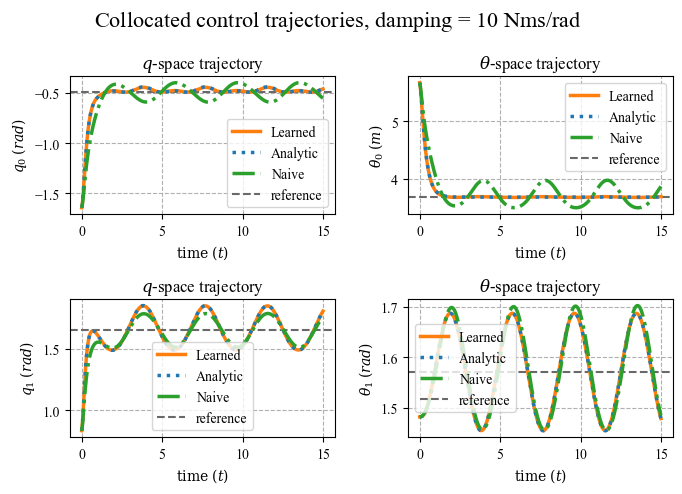

In [40]:
plt_col.save_trajectory_plots(rp, dt, t_end, xy_des, q_des, th_des_ana, save_dir, xy_multiseries, q_multiseries, th_multiseries)

In [ ]:
def make_boxplot(values_nn, values_ana, values_q, plot_title, ylabel):
	fig, ax = plt.subplots(figsize=(5, 2))
	ax.set_ylabel(ylabel)
	ax.set_title(plot_title)

	boxdata = [values_nn, values_ana, values_q]
	colors = ["tab:orange", "tab:blue", "tab:green"]
	labels = [r"$\theta_L$", r"$\theta_A$", r"$q$"]

	bplot = ax.boxplot(boxdata,
					patch_artist=True,  # fill with color
					tick_labels=labels)  # will be used to label x-ticks
	
	for median in bplot["medians"]:
		median.set_color("black")

	# fill with colors
	for patch, color in zip(bplot['boxes'], colors):
		patch.set_facecolor(color)
	plt.grid(linestyle="--", axis="y")
	plt.show()

def make_boxplot_double(values_nn, values_ana, values_q, plot_title, ylabel):
	fig, ax = plt.subplots(figsize=(5, 2))
	ax.set_ylabel(ylabel)
	ax.set_title(plot_title)

	boxdata = [values_nn, values_ana, values_q]
	colors = ["tab:orange", "tab:blue", "tab:green"]
	labels = [r"$\theta_L$", r"$\theta_A$", r"$q$"]

	bplot = ax.boxplot(boxdata,
					patch_artist=True,  # fill with color
					tick_labels=labels)  # will be used to label x-ticks
	
	for median in bplot["medians"]:
		median.set_color("black")

	# fill with colors
	for patch, color in zip(bplot['boxes'], colors):
		patch.set_facecolor(color)
	plt.grid(linestyle="--", axis="y")
	plt.show()

In [ ]:
make_boxplot(pdata_nn_sims["rmse_s"], pdata_ana_sims["rmse_s"], pdata_naive_sims["rmse_s"], plot_title = "Steady state error, collocated & naive controller", ylabel="RMSE " + r"$(m)$")
make_boxplot(pdata_nn_sims["control_effort_s"], pdata_ana_sims["control_effort_s"], pdata_naive_sims["control_effort_s"], plot_title = "Control effort, collocated & naive controller", ylabel="Mean control effort " + r"$(u^2)$")
make_boxplot(pdata_nn_sims["settling_time_s"], pdata_ana_sims["settling_time_s"], pdata_naive_sims["settling_time_s"], plot_title = "Settling time, collocated & naive controller", ylabel="Settling time " + r"$(s)$")
make_boxplot(pdata_nn_sims["overshoot_s"], pdata_ana_sims["overshoot_s"], pdata_naive_sims["overshoot_s"], plot_title = "Overshoot, collocated & naive controller", ylabel="Overshoot" + r"$(\%)$")


#### Performance calculations for $q$ (damped)

In [ ]:
def calc_settling_time_q(q_abs_error_series, q_des, q_start, settling_time_threshold = 0.05):

	"""
	Function to calculate settling time of a simulation
	"""
	q_distance = torch.norm(q_des - q_start)

	tolerance = settling_time_threshold * q_distance

	q_l2_error_series = torch.norm(q_abs_error_series, dim = 1)

	within_tolerance = q_l2_error_series <= tolerance
	reverse_within_tolerance = within_tolerance.flip(0)

	rev_cum_and = torch.cumprod(reverse_within_tolerance.to(torch.uint8), dim=0).bool()
	suffix_all_true = rev_cum_and.flip(0)

	idx = torch.nonzero(suffix_all_true).squeeze(0)

	if idx.numel() == 0:
		print("Did not reach within 5% tolerance.")
		settling_time = q_abs_error_series.size()[0] * dt
	else:
		settling_idx = idx[0].item()
		settling_time = settling_idx * dt
		print(f"Reached within 5% tolerance at t = {settling_time:.2f} seconds.")

	return settling_time, tolerance

def calc_final_error_q(q_real_series, q_des):

	final_value = q_real_series[-1].unsqueeze(0)
	final_errors = q_des - final_value
	final_error = torch.norm(final_errors)

	return final_error.item()

def calc_overshoot_q(q_real_series, q_des, q_start):

	overshoot_percents = torch.empty((2))


	for i in range(q_real_series.size(1)):
		qi_series = q_real_series[:, i]
		qi_des = q_des[0, i]
		qi_start = q_start[0, i]
		distance = qi_des - qi_start

		if distance >= 0: #Then that means q0 starts at a smaller angle, and ends at a larger one. We are looking for the largest value
			qi_largest = torch.max(qi_series)
			overshoot = torch.clamp(qi_des - qi_largest, max = 0.)
		elif distance < 0:
			qi_smallest = torch.min(qi_series)
			overshoot = torch.clamp(qi_des - qi_smallest, min = 0.)
		
		overshoot_ratio = torch.abs(overshoot/distance)
		overshoot_percents[i] = overshoot_ratio * 100

	overshoot_percent = torch.norm(overshoot_percents)
	
	return overshoot_percent.item()


In [ ]:
def plot_settling_q(q_l2_error_series, tolerance, settling_time):
	# Time vector (same length as error series)
	t_series = torch.arange(0, t_end, dt)

	# Detach if needed (for plotting outside torch computation graph)
	error_np = q_l2_error_series.detach().cpu().numpy()
	t_np = t_series.cpu().numpy()

	# Plot
	plt.figure(figsize=(4, 3))
	plt.plot(t_np, error_np, label=r"$\bar{q}_{0} - q_{0}$", color='tab:blue')
	plt.axhline(y=-tolerance.item(), color='tab:red', linestyle='--', label="-5% Tolerance")
	plt.axhline(y=tolerance.item(), color='tab:red', linestyle='--', label="5% Tolerance")
	plt.axvline(x=settling_time, color='tab:green', linestyle='--', label="Settling Time")

	plt.title("Error of " + r"$q$" + " vs Time")
	plt.xlabel("Time [s]")
	plt.ylabel("Error [rad]")
	plt.xlim(0, t_end)
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

#### Multiple simulations, with damping

xy_start: tensor([ 1.4992, -0.6482], device='cuda:0')
xy_des: tensor([2.0000, 1.3175], device='cuda:0')
Time: [0.0/15.0.0]
Time: [5.0/15.0.0]
Time: [10.0/15.0.0]
Time: [0.0/15.0.0]
Time: [5.0/15.0.0]
Time: [10.0/15.0.0]
Time: [0.0/15.0.0]
Time: [5.0/15.0.0]
Time: [10.0/15.0.0]


NameError: name 'calc_settling_time_q' is not defined

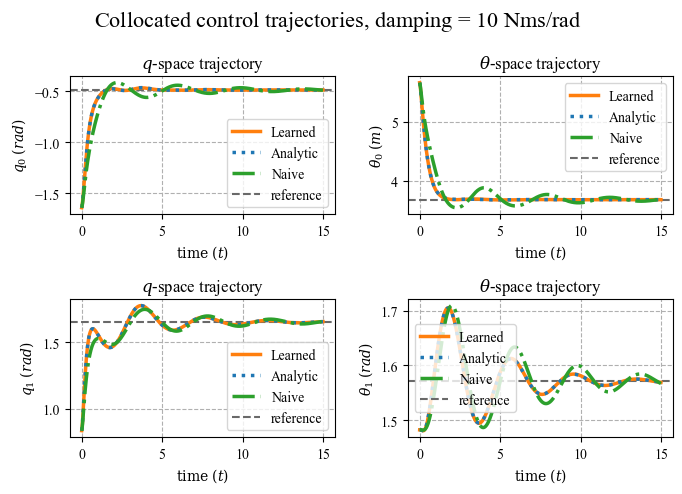

In [41]:
damping_value = 10
C_damp = torch.tensor([[float(damping_value), 0.], [0., float(damping_value)]]).to(device)

dict_save_dir = "collocated_results/performance_logs/damped_c=" + str(damping_value)
dict_save_names = ["pdata_nn_sims_single_sim.pt", "pdata_ana_sims_single_sim.pt", "pdata_naive_sims_single_sim.pt"]

use_neural_net = True
model_nn = autoencoders.Autoencoder_double(rp).to(device)
model_location = '../Double_Pendulum/Learning/Models/NN_optimal/NN_0.pth'
model_nn.load_state_dict(torch.load(model_location, weights_only=True))
sim_type = "group"
stride = 1


load_logs = False




if load_logs:
	pdata_nn_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[0])
	pdata_ana_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[1])
	pdata_naive_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[2])
else:
	pdata_nn_sims_damp = {
		"settling_time_s": [],
		"overshoot_s": [],
		"final_error_s": [],
		"control_effort_s": []
	}

	pdata_ana_sims_damp = {
		"settling_time_s": [],
		"overshoot_s": [],
		"final_error_s": [],
		"control_effort_s": []
	}

	pdata_naive_sims_damp = {
		"settling_time_s": [],
		"overshoot_s": [],
		"final_error_s": [],
		"control_effort_s": []
	}






performance_data_dicts = [pdata_nn_sims_damp, pdata_ana_sims_damp, pdata_naive_sims_damp]


for i, (xy_des, xy_start) in enumerate(zip(xy_des_series, xy_start_series)):

	print("xy_start:", xy_start)
	print("xy_des:", xy_des)

	timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

	save_dir = "collocated_results/batched_sims/damped/simulation_" + sim_type + f"_{timestamp}"
	
	try:
		# Simulations
		nns_data, q_des, q_start, th_des_ana, th_start_ana = sim_collocated_nn(xy_start, xy_des, timestamp, model_nn, C_damp)

		anas_data = sim_collocated_ana(xy_start, xy_des, timestamp, model_ana, C_damp)

		naives_data = sim_collocated_naive(xy_start, xy_des, timestamp, C_damp)

	except Exception as e:
		print(f"Simulation failed at index {i} with error: {e}")
		continue

	simulation_data_multi = [nns_data, anas_data, naives_data]
	
	plt_col.save_metadata(rp, dt, t_end, timestamp, xy_des, xy_start, Kp, Kd, sim_type, use_neural_net, model_cw, model_location, save_dir)

	xy_multiseries = (nns_data["xy_real_s"], anas_data["xy_real_s"], naives_data["xy_real_s"])
	q_multiseries = (nns_data["q_real_s"], anas_data["q_real_s"], naives_data["q_real_s"])
	th_multiseries = (nns_data["th_ana_s"], anas_data["th_ana_s"], naives_data["th_ana_s"])

	plt_col.save_trajectory_plots(rp, dt, t_end, xy_des, q_des, th_des_ana, save_dir, xy_multiseries, q_multiseries, th_multiseries)
	#plt_col.create_video(rp, dt, t_end, plotter, stride, q_multiseries, xy_des, save_dir)

	
	for j, (dict, data) in enumerate(zip(performance_data_dicts, simulation_data_multi)):

		q_error_series = q_des - data["q_real_s"]
		q_l2_error_series = torch.norm(q_error_series, dim = 1)
		q_abs_error_series = torch.abs(q_error_series)
		
		settling_time, tolerance = calc_settling_time_q(q_abs_error_series, q_des, q_start, settling_time_threshold)
		final_error = calc_final_error_q(data["q_real_s"], q_des)
		overshoot = calc_overshoot_q(data["q_real_s"], q_des, q_start)

		control_effort = data["u_s"]**2
		mean_control_effort = torch.mean(control_effort).item()


		dict["settling_time_s"].append(settling_time)
		dict["final_error_s"].append(final_error)
		dict["control_effort_s"].append(mean_control_effort)
		dict["overshoot_s"].append(overshoot)

		plot_settling_q(q_l2_error_series, tolerance, settling_time)

		save_performance_dict(dict, dict_save_dir, dict_save_names[j])


In [ ]:
make_boxplot(pdata_nn_sims_damp["final_error_s"], pdata_ana_sims_damp["final_error_s"], pdata_naive_sims_damp["final_error_s"], plot_title = "Steady state error, different controllers, damped", ylabel="RMSE " + r"$(rad)$")
make_boxplot(pdata_nn_sims_damp["control_effort_s"], pdata_ana_sims_damp["control_effort_s"], pdata_naive_sims_damp["control_effort_s"], plot_title = "Control effort, different controllers, damped", ylabel="Mean control effort " + r"$(u^2)$")
make_boxplot(pdata_nn_sims_damp["settling_time_s"], pdata_ana_sims_damp["settling_time_s"], pdata_naive_sims_damp["settling_time_s"], plot_title = "Settling time, different controllers, damped", ylabel="Settling time " + r"$(s)$")
make_boxplot(pdata_nn_sims_damp["overshoot_s"], pdata_ana_sims_damp["overshoot_s"], pdata_naive_sims_damp["overshoot_s"], plot_title = "Overshoot, different controllers, damped", ylabel="Overshoot" + r"$(\%)$")

xy_start: tensor([ 1.4992, -0.6482], device='cuda:0')
xy_des: tensor([2.0000, 1.3175], device='cuda:0')
Time: [0.0/15.0.0]
Time: [5.0/15.0.0]
Time: [10.0/15.0.0]
Time: [0.0/15.0.0]
Time: [5.0/15.0.0]
Time: [10.0/15.0.0]
Time: [0.0/15.0.0]
Time: [5.0/15.0.0]
Time: [10.0/15.0.0]


NameError: name 'calc_settling_time_q' is not defined

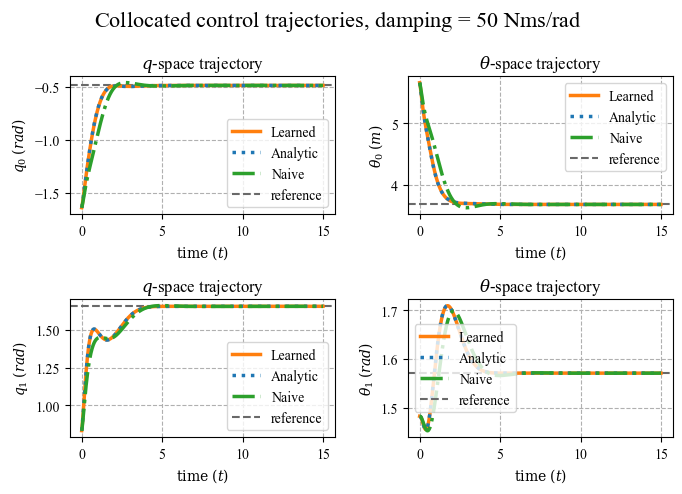

In [43]:
damping_value = 50
C_damp = torch.tensor([[float(damping_value), 0.], [0., float(damping_value)]]).to(device)

dict_save_dir = "collocated_results/performance_logs/damped_c=" + str(damping_value)
dict_save_names = ["pdata_nn_sims.pt_single_sim", "pdata_ana_sims_single_sim.pt", "pdata_naive_sims_single_sim.pt"]

use_neural_net = True
model_nn = autoencoders.Autoencoder_double(rp).to(device)
model_location = '../Double_Pendulum/Learning/Models/NN_optimal/NN_0.pth'
model_nn.load_state_dict(torch.load(model_location, weights_only=True))
sim_type = "group"
stride = 1


load_logs = False




if load_logs:
	pdata_nn_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[0])
	pdata_ana_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[1])
	pdata_naive_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[2])
else:
	pdata_nn_sims_damp = {
		"settling_time_s": [],
		"overshoot_s": [],
		"final_error_s": [],
		"control_effort_s": []
	}

	pdata_ana_sims_damp = {
		"settling_time_s": [],
		"overshoot_s": [],
		"final_error_s": [],
		"control_effort_s": []
	}

	pdata_naive_sims_damp = {
		"settling_time_s": [],
		"overshoot_s": [],
		"final_error_s": [],
		"control_effort_s": []
	}






performance_data_dicts = [pdata_nn_sims_damp, pdata_ana_sims_damp, pdata_naive_sims_damp]


for i, (xy_des, xy_start) in enumerate(zip(xy_des_series, xy_start_series)):

	print("xy_start:", xy_start)
	print("xy_des:", xy_des)

	timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

	save_dir = "collocated_results/batched_sims/damped/simulation_" + sim_type + f"_{timestamp}"
	
	try:
		# Simulations
		nns_data, q_des, q_start, th_des_ana, th_start_ana = sim_collocated_nn(xy_start, xy_des, timestamp, model_nn, C_damp)

		anas_data = sim_collocated_ana(xy_start, xy_des, timestamp, model_ana, C_damp)

		naives_data = sim_collocated_naive(xy_start, xy_des, timestamp, C_damp)

	except Exception as e:
		print(f"Simulation failed at index {i} with error: {e}")
		continue

	simulation_data_multi = [nns_data, anas_data, naives_data]
	
	plt_col.save_metadata(rp, dt, t_end, timestamp, xy_des, xy_start, Kp, Kd, sim_type, use_neural_net, model_cw, model_location, save_dir)

	xy_multiseries = (nns_data["xy_real_s"], anas_data["xy_real_s"], naives_data["xy_real_s"])
	q_multiseries = (nns_data["q_real_s"], anas_data["q_real_s"], naives_data["q_real_s"])
	th_multiseries = (nns_data["th_ana_s"], anas_data["th_ana_s"], naives_data["th_ana_s"])

	plt_col.save_trajectory_plots(rp, dt, t_end, xy_des, q_des, th_des_ana, save_dir, xy_multiseries, q_multiseries, th_multiseries)
	#plt_col.create_video(rp, dt, t_end, plotter, stride, q_multiseries, xy_des, save_dir)

	
	for j, (dict, data) in enumerate(zip(performance_data_dicts, simulation_data_multi)):

		q_error_series = q_des - data["q_real_s"]
		q_l2_error_series = torch.norm(q_error_series, dim = 1)
		q_abs_error_series = torch.abs(q_error_series)
		
		settling_time, tolerance = calc_settling_time_q(q_abs_error_series, q_des, q_start, settling_time_threshold)
		final_error = calc_final_error_q(data["q_real_s"], q_des)
		overshoot = calc_overshoot_q(data["q_real_s"], q_des, q_start)

		control_effort = data["u_s"]**2
		mean_control_effort = torch.mean(control_effort).item()


		dict["settling_time_s"].append(settling_time)
		dict["final_error_s"].append(final_error)
		dict["control_effort_s"].append(mean_control_effort)
		dict["overshoot_s"].append(overshoot)

		plot_settling_q(q_l2_error_series, tolerance, settling_time)

		save_performance_dict(dict, dict_save_dir, dict_save_names[j])


In [ ]:
make_boxplot(pdata_nn_sims_damp["final_error_s"], pdata_ana_sims_damp["final_error_s"], pdata_naive_sims_damp["final_error_s"], plot_title = "Steady state error, different controllers, damped", ylabel="RMSE " + r"$(rad)$")
make_boxplot(pdata_nn_sims_damp["control_effort_s"], pdata_ana_sims_damp["control_effort_s"], pdata_naive_sims_damp["control_effort_s"], plot_title = "Control effort, different controllers, damped", ylabel="Mean control effort " + r"$(u^2)$")
make_boxplot(pdata_nn_sims_damp["settling_time_s"], pdata_ana_sims_damp["settling_time_s"], pdata_naive_sims_damp["settling_time_s"], plot_title = "Settling time, different controllers, damped", ylabel="Settling time " + r"$(s)$")
make_boxplot(pdata_nn_sims_damp["overshoot_s"], pdata_ana_sims_damp["overshoot_s"], pdata_naive_sims_damp["overshoot_s"], plot_title = "Overshoot, different controllers, damped", ylabel="Overshoot" + r"$(\%)$")

In [ ]:
damping_value = 10
C_damp = torch.tensor([[float(damping_value), 0.], [0., float(damping_value)]]).to(device)

dict_save_dir = "collocated_results/performance_logs/damped_c=" + str(damping_value)
dict_save_names = ["pdata_nn_sims.pt", "pdata_ana_sims.pt", "pdata_naive_sims.pt"]

load_logs = True


if load_logs:
	pdata_nn_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[0])
	pdata_ana_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[1])
	pdata_naive_sims_damp = load_performance_dict(dict_save_dir + "/" + dict_save_names[2])

In [ ]:
make_boxplot(pdata_nn_sims_damp["final_error_s"], pdata_ana_sims_damp["final_error_s"], pdata_naive_sims_damp["final_error_s"], plot_title = "Steady state error, different controllers, damped", ylabel="RMSE " + r"$(rad)$")
make_boxplot(pdata_nn_sims_damp["control_effort_s"], pdata_ana_sims_damp["control_effort_s"], pdata_naive_sims_damp["control_effort_s"], plot_title = "Control effort, different controllers, damped", ylabel="Mean control effort " + r"$(u^2)$")
make_boxplot(pdata_nn_sims_damp["settling_time_s"], pdata_ana_sims_damp["settling_time_s"], pdata_naive_sims_damp["settling_time_s"], plot_title = "Settling time, different controllers, damped", ylabel="Settling time " + r"$(s)$")
make_boxplot(pdata_nn_sims_damp["overshoot_s"], pdata_ana_sims_damp["overshoot_s"], pdata_naive_sims_damp["overshoot_s"], plot_title = "Overshoot, different controllers, damped", ylabel="Overshoot" + r"$(\%)$")

In [ ]:
plt_col.save_trajectory_plots(rp, dt, t_end, xy_des, q_des, th_des_ana, save_dir, xy_multiseries, q_multiseries, th_multiseries)